In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import skimage
from pathlib import Path
import shutil

In [ ]:
from skimage import io
from skimage import transform
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
local_prefix = "D:/DLSS/"
colab_prefix = "/content/drive/Shareddrives/DLSS Winter Project/"
use_colab = True
path_prefix = colab_prefix if use_colab else local_prefix

# Create training and testing datasets

In [ ]:
data_folder = "/content/drive/Shareddrives/DLSS Winter Project/DATASET/Images/"
final_data_folder = "/content/drive/Shareddrives/DLSS Winter Project/FINAL_DATASET"

In [ ]:
# os.mkdir(final_data_folder + '/train')
# os.mkdir(final_data_folder + '/train/LR')
# os.mkdir(final_data_folder + '/train/HR')
# os.mkdir(final_data_folder + '/test')
# os.mkdir(final_data_folder + '/test/LR')
# os.mkdir(final_data_folder + '/test/HR')

In [ ]:
# for path in os.listdir(data_folder):
#     img = io.imread(data_folder + path)
#     print(img.shape)
#     break

In [ ]:
# img_names=[]
# for path in os.listdir("/content/drive/Shareddrives/DLSS Winter Project/FINAL_DATASET/train/LR"):
#   img_names.append(data_folder+path)

In [ ]:
# len(img_names)

In [ ]:
# n_files=len(img_names)
# batch_size = 200
# n_batches=math.ceil(n_files/batch_size)
# train_count=180
# cnt=0

In [ ]:
# cnt1=0
# cnt=0
# for i in range(n_batches):
#   cnt1+=1
#   print(cnt1)
#   images=[]
#   for j in range(batch_size):
#     di=Path(img_names[cnt])
#     if(di.exists()):
#       img = io.imread(img_names[cnt])
#       img.astype(np.uint8)
#       resize_high_res = transform.resize(img, (720, 1280, 3))
#       resize_low_res = transform.resize(img, (360, 640, 3))
#       images.append((resize_low_res, resize_high_res))
#     else:
#       print("not_found")
#     if(cnt%50==0):
#       print(cnt)
#     cnt+=1
#   images = np.array(images, dtype='object')
#   np.random.shuffle(images)
#   dirpath = Path(final_data_folder)
#   for j, (low_res, high_res) in enumerate(images[:train_count]):
#     skimage.io.imsave(f'{final_data_folder}/train/LR/B20094{cnt-199+j}.png', low_res)
#     skimage.io.imsave(f'{final_data_folder}/train/HR/B20094{cnt-199+j}.png', high_res)

#   for j, (low_res, high_res) in enumerate(images[train_count:]):
#     skimage.io.imsave(f'{final_data_folder}/test/LR/B20094{cnt-199+j + train_count}.png', low_res)
#     skimage.io.imsave(f'{final_data_folder}/test/HR/B20094{cnt-199+j + train_count}.png', high_res)

#   del images

# Set Parameters

In [ ]:
# Dimensions of the images inside the dataset.
# NOTE: The image sizes must be compatible meaning output_dimensions / input_dimensions is a multiple of 2
input_dimensions = (360, 640, 3)

# Dimensions of the images inside the dataset.
# NOTE: The image sizes must be compatible meaning output_dimensions / input_dimensions is a multiple of 2
output_dimensions = (720, 1280, 3)

# How many times to increase the resolution by 2 (by appling the UpSampling2D layer)
super_sampling_ratio = int(output_dimensions[0] / input_dimensions[0] / 2)

# Folder where you want to save to model as well as generated samples
model_path = "/content/drive/Shareddrives/DLSS Winter Project/FINAL_DATASET/results"

# How many epochs between saving your model
interval = 1

# How many epochs to train the model
max_epochs = 200

# How many images to train at one time. Ideally this number would be a factor of the size of your dataset
batch = 5

# How many convolutional filters for each convolutional layer of the generator and the discrminator
conv_filters = 32

# Size of kernel used in the convolutional layers
kernel = (3,3)

# Boolean flag, set to True if the data has pngs to remove alpha layer from images
png = True

In [ ]:
super_sampling_ratio

1

# Create Deep Convolutional GAN Class

In [ ]:
class DCGAN():
    
    # Initialize parameters, generator, and discriminator models
    def __init__(self):

        # Set dimensions of the output image
        self.img_rows = output_dimensions[0]
        self.img_cols = output_dimensions[1]
        self.channels = output_dimensions[2]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Shape of low resolution input image
        self.latent_dim = input_dimensions
        
        # Chose optimizer for the models
        self.discriminator_optimizer = Adam(0.0002, 0.9)
        self.generator_optimizer = Adam(0.0002, 0.9)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.discriminator_optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes low resolution images as input and generates high resolution images
        z = Input(shape = self.latent_dim)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.generator_optimizer)

        self.checkpoint = tf.train.Checkpoint(generator=self.generator, discriminator=self.discriminator, generator_optimizer=self.generator_optimizer, discriminator_optimizer=self.discriminator_optimizer)

        self.last_run_epochs = 0
        for files in os.listdir(model_path):
          if files[:5] == "epoch":
            self.last_run_epochs = max(self.last_run_epochs, int(files[6:-4]))
        print("last epoch is ", self.last_run_epochs)

            
        # Folder containing input (low resolution) dataset
        input_path = path_prefix + f'FINAL_DATASET/train/LR'

        # Initializing arrays for data and image file paths
        paths = []
        
        # Get the file paths of all image files in this folder
        for r, d, f in os.walk(input_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    paths.append(os.path.join(r, file))

        self.train_size=len(paths)

        self.train_in_paths=[]
        self.train_out_paths=[]

         # Folder containing input (low resolution) dataset
        input_path = path_prefix + f'FINAL_DATASET/train/LR'

        # Folder containing output (high resolution) dataset
        output_path = path_prefix + f'FINAL_DATASET/train/HR'
        
        # Get the file paths of all image files in this folder
        for r, d, f in os.walk(output_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    self.train_out_paths.append(os.path.join(r, file))

        self.train_out_size=len(self.train_out_paths)
        
        # Get the file paths of all image files in this folder
        for r, d, f in os.walk(input_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    self.train_in_paths.append(os.path.join(r, file))

        self.train_in_size=len(self.train_in_paths)


        self.test_in_paths=[]
        self.test_out_paths=[]

         # Folder containing input (low resolution) dataset
        input_path = path_prefix + f'FINAL_DATASET/test/LR'

        # Folder containing output (high resolution) dataset
        output_path = path_prefix + f'FINAL_DATASET/test/HR'
        
        # Get the file paths of all image files in this folder
        for r, d, f in os.walk(output_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    self.test_out_paths.append(os.path.join(r, file))

        self.test_out_size=len(self.test_out_paths)
        
        # Get the file paths of all image files in this folder
        for r, d, f in os.walk(input_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    self.test_in_paths.append(os.path.join(r, file))

        self.test_in_size=len(self.test_in_paths)

        
    
    # Define Generator model
    def build_generator(self):

        model = Sequential()
        
        # 1st Convolutional Layer / Input Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same", input_shape=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        
        # Upsample the data as many times as needed to reach output resolution
        for i in range(super_sampling_ratio):
        
            # Super Sampling Convolutional Layer
            model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
            model.add(LeakyReLU(alpha=0.2))

            # Upsample the data (Double the resolution)
            model.add(UpSampling2D())

        # Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        # Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        
        # Final Convolutional Layer (Output Layer)
        model.add(Conv2D(3, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=self.latent_dim)
        img = model(noise)

        return Model(noise, img)

    # Define Discriminator model
    def build_discriminator(self):

        model = Sequential()

        # Input Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, input_shape=self.img_shape,activation = "relu", padding="same"))
        
        # Downsample the image as many times as needed 
        for i in range(super_sampling_ratio):
            
            # Convolutional Layer
            model.add(Conv2D(conv_filters, kernel_size=kernel))
            model.add(LeakyReLU(alpha=0.2))
        
            # Downsample the data (Half the resolution)
            model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, strides = 2))
        model.add(LeakyReLU(alpha=0.2))

        # Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, strides = 2))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Flatten())
        
        # Output Layer
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)



        # load data from specified file path 
    def load_data(self, train_test,st,end):

        # Folder containing input (low resolution) dataset
        input_path = path_prefix + f'FINAL_DATASET/{train_test}/LR'

        # Folder containing output (high resolution) dataset
        output_path = path_prefix + f'FINAL_DATASET/{train_test}/HR'

        # Initializing arrays for data and image file paths
        data = []
        small = []
        
        if(train_test=='train'):
            # For each file add high resolution image to array
            for i in range(st,end):
                  path=self.train_out_paths[i]
                  img = Image.open(path)
                  
                  # Resize Image
                  # y = np.array(img.resize((self.img_rows,self.img_cols)))
                  y = np.array(img)
                  
                  # Remove alpha layer if imgaes are PNG
                  if('png' in path):
                      y = y[...,:3]
                      
                  data.append(y)
              
            # For each file add low resolution image to array
            for i in range(st,end):
                  path=self.train_in_paths[i]
                  img = Image.open(path)
                  
                  # Resize Image
                  # x = np.array(img.resize((self.latent_dim[0],self.latent_dim[1])))
                  x = np.array(img)
                  
                  # Remove alpha layer if imgaes are PNG
                  if(png):
                      x = x[...,:3]

                  small.append(x)

        else:

            for i in range(st,end):
                  path=self.test_out_paths[i]
                  img = Image.open(path)
                  
                  # Resize Image
                  # y = np.array(img.resize((self.img_rows,self.img_cols)))
                  y = np.array(img)
                  
                  # Remove alpha layer if imgaes are PNG
                  if('png' in path):
                      y = y[...,:3]
                      
                  data.append(y)
              
            # For each file add low resolution image to array
            for i in range(st,end):
                  path=self.test_in_paths[i]
                  img = Image.open(path)
                  
                  # Resize Image
                  # x = np.array(img.resize((self.latent_dim[0],self.latent_dim[1])))
                  x = np.array(img)
                  
                  # Remove alpha layer if imgaes are PNG
                  if(png):
                      x = x[...,:3]

                  small.append(x)
          
        
            
        # Return x_train and self.y_train reshaped to 4 dimensions
        y_train = np.array(data)
        y_train = y_train.reshape(len(data),self.img_rows,self.img_cols,self.channels)
        x_train = np.array(small)
        x_train = x_train.reshape(len(small),self.latent_dim[0],self.latent_dim[1],self.latent_dim[2])
        
        del data
        del small
        
        # Shuffle indexes of data
        X_shuffle, Y_shuffle = shuffle(x_train, y_train)
        
        return X_shuffle, Y_shuffle



    
    # Train the Generative Adversarial Network
    def train(self, epochs, batch_size, save_interval):
        
        # Prevent script from crashing from bad user input
        if(epochs <= 0):
            epochs = 1
        
        if(batch_size <= 0):
            batch_size = 1

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Placeholder arrays for Loss function values
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))
        
        self.X_test, self.Y_test = self.load_data('test',100,200)
        self.X_test = self.X_test / 255 
        self.Y_test = self.Y_test / 255
        # Training the GAN
        print("last epoch is ", self.last_run_epochs)
        for epoch in range(self.last_run_epochs + 1, epochs + 1):
            
            # Initialize indexes for training data
            start = 2000
            end = start + batch_size
            
            # Iterate through dataset training one batch at a time
            # self.train_size=500
            for i in range(int(min(self.train_size,2000)/batch_size)):

                print(start,end," are start and end")

                # Load the dataset
                self.X_train, self.Y_train = self.load_data('train',start,end)
                
                # Normalizing data to be between 0 and 1
                self.X_train = self.X_train / 255
                self.Y_train = self.Y_train / 255
                
                # Array to sum up all loss function values
                discriminator_loss_real = []
                discriminator_loss_fake = []
                generator_loss = []
                
                # Get batch of images
                imgs_output = self.Y_train
                imgs_input = self.X_train

                print("starting training")

                # Train Discriminator

                # Make predictions on current batch using generator
                gen_imgs = self.generator.predict(imgs_input)

                # Train the discriminator (real classified as ones and generated as zero)
                d_loss_real = self.discriminator.train_on_batch(imgs_output, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                #  Train Generator

                # Train the generator (wants discriminator to mistake images as real)
                g_loss = self.combined.train_on_batch(imgs_input, valid)
                
                # Add loss for current batch to sum over entire epoch
                discriminator_loss_real.append(d_loss[0])
                discriminator_loss_fake.append(d_loss[1])
                generator_loss.append(g_loss)
                
                # Increment image indexes
                start = start + batch_size
                end = end + batch_size
                
            
            # Get average loss over the entire epoch
            loss_data = [np.average(discriminator_loss_real),np.average(discriminator_loss_fake),np.average(generator_loss)]
            
            #save loss history
            g_loss_epochs[epoch - 1] = loss_data[2]
            
            # Average loss of real data classification and fake data accuracy
            d_loss_epochs[epoch - 1] = (loss_data[0] + (1 - loss_data[1])) / 2
                
            # Print average loss over current epoch
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, loss_data[0], loss_data[1]*100, loss_data[2]))

            # If epoch is at interval, save model and generate image samples
            if epoch % save_interval == 0:
                
                # Select 8 random indexes
                idx = np.random.randint(0, self.X_test.shape[0], 8)
                
                # Get batch of testing images
                x_points = self.X_test[idx]
                
                # Make predictions on batch of testing images
                predicted_imgs = self.generator.predict(x_points)
                
                # Undo normalization of data. Update values to be between 0 and 255 for RGB image
                predicted_imgs = np.array(predicted_imgs) * 255
                np.clip(predicted_imgs, 0, 255, out=predicted_imgs)
                predicted_imgs = predicted_imgs.astype('uint8')
                x_points = np.array(x_points) * 255
                np.clip(x_points, 0, 255, out=x_points)
                x_points = x_points.astype('uint8')
                
                interpolated_imgs = []
                
                # Interpolate low resolution images for comparison
                for x in range(len(x_points)):
                    img = Image.fromarray(x_points[x])
                    interpolated_imgs.append(np.array(img.resize((self.img_cols, self.img_rows))))
                
                # Plot the predictions next to the interpolated images
                self.generator.save('/content/drive/Shareddrives/DLSS Winter Project/FINAL_DATASET/results\generator.h5')
                self.save_imgs(epoch, predicted_imgs, interpolated_imgs)
        return g_loss_epochs, d_loss_epochs
    
    # Save the model and generate prediction samples for a given epoch
    def save_imgs(self, epoch, gen_imgs, interpolated):
        # Define number of columns and rows
        r, c = 4, 4
        
        # Placeholder array for MatPlotLib Figure Subplots
        subplots = []
        
        # Create figure with title
        fig = plt.figure(figsize= (40, 40))
        fig.suptitle("Epoch: " + str(epoch), fontsize=65)
        
        # Initialize counters needed to track indexes across multiple arrays
        img_count = 0;
        index_count = 0;
        x_count = 0;
        
        # Loop through columns and rows of the figure
        for i in range(1, c+1):
            for j in range(1, r+1):
                # If row is even, plot the predictions
                if(j % 2 == 0):
                    img = gen_imgs[index_count]
                    index_count = index_count + 1
                # If row is odd, plot the interpolated images
                else:
                    img = interpolated[x_count]
                    x_count = x_count + 1
                # Add image to figure, add subplot to array
                subplots.append(fig.add_subplot(r, c, img_count + 1))
                plt.imshow(img)
                img_count = img_count + 1
        
        # Add title to columns of figure
        subplots[0].set_title("Interpolated", fontsize=45)
        subplots[1].set_title("Predicted", fontsize=45)
        subplots[2].set_title("Interpolated", fontsize=45)
        subplots[3].set_title("Predicted", fontsize=45)
                
        # Save figure to .png image in specified folder
        fig.savefig(model_path + "/epoch_%d.png" % (epoch))
        plt.close()

        # save model to .h5 file in specified folder
        self.checkpoint.save(file_prefix = os.path.join(model_path, "ckpt"))

    def save_model(self):
      self.generator.save(model_path + "\\generator"+ ".h5")

# Initialize Generator and Discriminator Models

# Train GAN

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Tue Apr 12 07:49:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
dcgan = DCGAN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 720, 1280, 32)     896       
                                                                 
 conv2d_1 (Conv2D)           (None, 718, 1278, 32)     9248      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 718, 1278, 32)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 359, 639, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 179, 319, 32)      9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 179, 319, 32)      0         
                                                        

In [ ]:
# # max_epochs = 10
dcgan.checkpoint.restore(tf.train.latest_checkpoint(model_path))

In [ ]:
g_loss, d_loss = dcgan.train(epochs=max_epochs, batch_size=batch, save_interval=interval)

In [ ]:
dcgan.save_model()

# Prediction

In [ ]:
X_test, Y_test = dcgan.load_data('test',300,305)

In [ ]:
X_train, Y_train = dcgan.load_data('train',300,305)

In [ ]:
model = tf.keras.models.load_model(model_path + "\\generator"+ ".h5")
test_img = X_test[0]
test_img = np.array([test_img])
test_img.shape

(1, 360, 640, 3)

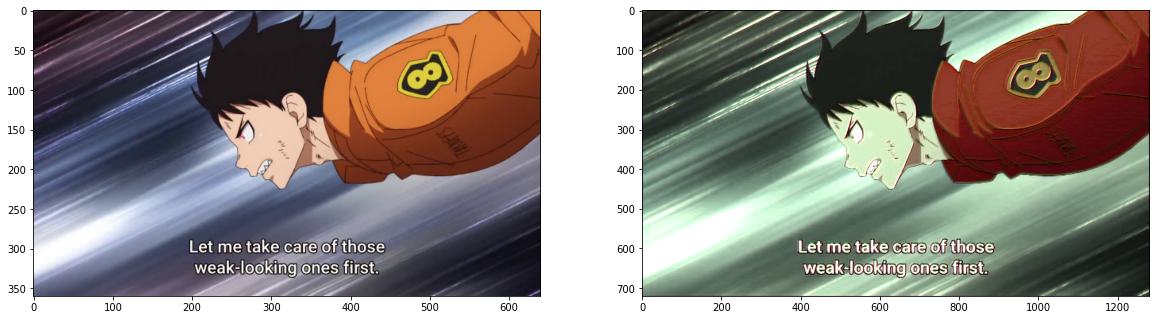

In [ ]:
predicted_imgs = model.predict(test_img)
np.clip(predicted_imgs, 0, 255, out=predicted_imgs)
predicted_imgs = predicted_imgs.astype('uint8')
#predicted_imgs = predicted_imgs.reshape(predicted_imgs.shape[1:])
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(test_img[0])
ax[1].imshow(predicted_imgs[0])

In [ ]:
plt.imsave(fname='/content/drive/Shareddrives/DLSS Winter Project/FINAL_DATASET/results\lurred.jpg',arr=test_img[0])
plt.imsave(fname='/content/drive/Shareddrives/DLSS Winter Project/FINAL_DATASET/results\prediction.jpg',arr=predicted_imgs[0])

# Plot Loss

In [ ]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()